In [4]:
import pandas as pd
import seaborn as sns


In [114]:
cols = ['user-mboxsha1', 'musicbrainz-artist-id', 'artist-name', 'plays']
data_artists = pd.read_csv("lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv", sep="\t", names=cols, header=None)
data_artists

,user-mboxsha1,musicbrainz-artist-id,artist-name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
...,...,...,...,...
17535650,"sep 20, 2008",7ffd711a-b34d-4739-8aab-25e045c246da,turbostaat,12
17535651,"sep 20, 2008",9201190d-409f-426b-9339-9bd7492443e2,cuba missouri,11
17535652,"sep 20, 2008",e7cf7ff9-ed2f-4315-aca8-bcbd3b2bfa71,little man tate,11
17535653,"sep 20, 2008",f6f2326f-6b25-4170-b89d-e235b25508e8,sigur rós,10


In [115]:
cols = ['user-mboxsha1', 'gender', 'age', 'country', 'signup']
data_users = pd.read_csv("lastfm-dataset-360K/usersha1-profile.tsv", sep="\t", names=cols, header=None)
data_users

,user-mboxsha1,gender,age,country,signup
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"
...,...,...,...,...,...
359342,fffe7823f67b433b45f22056467db921c1d3d7d0,m,25.0,Germany,"Jun 24, 2006"
359343,fffe8637bd8234309e871409c7ebef99a720afc1,m,25.0,Brazil,"Sep 9, 2007"
359344,fffe8c7f952d9b960a56ed4dcb40a415d924b224,m,20.0,United States,"Aug 8, 2007"
359345,ffff9af9ae04d263dae91cb838b1f3a6725f5ffb,m,20.0,Russian Federation,"Dec 3, 2005"


In [116]:
df = pd.merge(data_artists, data_users, on='user-mboxsha1')

<AxesSubplot: xlabel='gender', ylabel='count'>

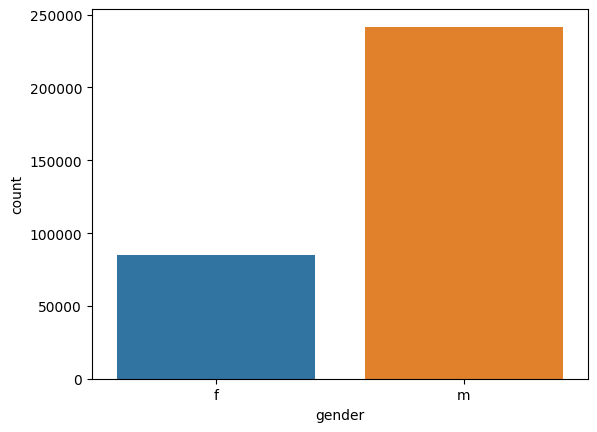

In [8]:
sns.countplot(x='gender', data=data_users)

In [9]:
from implicit.datasets.lastfm import get_lastfm
import h5py

artists, users, artist_user_plays = get_lastfm()

In [12]:
from implicit.nearest_neighbours import bm25_weight

# weight the matrix, both to reduce impact of users that have played the same artist thousands of times
# and to reduce the weight given to popular items
artist_user_plays = bm25_weight(artist_user_plays, K1=100, B=0.8)

# get the transpose since the most of the functions in implicit expect (user, item) sparse matrices instead of (item, user)
user_plays = artist_user_plays.T.tocsr()

In [13]:
from implicit.als import AlternatingLeastSquares
# on github it's mentioned to use params: factors=64, regularization=0.05, alpha=2.0
model = AlternatingLeastSquares(factors=50, regularization=0.01, alpha=2.0)
model.fit(user_plays)

  0%|          | 0/15 [00:00<?, ?it/s]

In [14]:
userid = 12345
ids, scores = model.recommend(userid, user_plays[userid], N=10, filter_already_liked_items=False)

In [18]:
# Use pandas to display the output in a table, pandas isn't a dependency of implicit otherwise
import numpy as np
import pandas as pd
pd.DataFrame({
    "artist": artists[ids],
    "score": scores,
    "already_liked": np.in1d(ids, user_plays[userid].indices)
})

,artist,score,already_liked
0,laibach,1.047629,False
1,mortiis,1.040169,True
2,puissance,1.036751,True
3,von thronstahl,1.008010,True
4,spiritual front,1.002762,False
5,the coffinshakers,0.964411,True
6,rome,0.956440,True
7,sopor aeternus & the ensemble of shadows,0.948346,False
8,triarii,0.947084,True
9,ordo rosarius equilibrio,0.943100,False


In [19]:
# get related items for the beatles (itemid = 25512)
ids, scores= model.similar_items(252512)

# display the results using pandas for nicer formatting
pd.DataFrame({"artist": artists[ids], "score": scores})

,artist,score
0,the beatles,1.000000
1,john lennon,0.994683
2,the beach boys,0.994366
3,the rolling stones,0.994149
4,the who,0.993516
5,bob dylan,0.992757
6,david bowie,0.992417
7,led zeppelin,0.992205
8,simon & garfunkel,0.992126
9,frank sinatra,0.991550


In [20]:
# Make recommendations for the first 1000 users in the dataset
userids = np.arange(len(users))
ids, scores = model.recommend(userids, user_plays[userids], N=1000)
ids, ids.shape

(array([[161850, 107119,  76757, ...,  49951,  35195, 233271],
        [111764, 128505, 262990, ..., 231352, 105910,  24596],
        [186835, 113686, 142885, ..., 252552, 202702, 189745],
        ...,
        [116857, 196777, 116871, ..., 108393,  94510, 163745],
        [179187,  50180, 108361, ..., 254541, 206691,  51658],
        [102288,  50561, 261820, ..., 247100, 252077, 129365]], dtype=int32),
 (358868, 1000))

In [117]:
rec_users = data_users[data_users['user-mboxsha1'].isin(users)]
rec_users

,user-mboxsha1,gender,age,country,signup
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"
...,...,...,...,...,...
359342,fffe7823f67b433b45f22056467db921c1d3d7d0,m,25.0,Germany,"Jun 24, 2006"
359343,fffe8637bd8234309e871409c7ebef99a720afc1,m,25.0,Brazil,"Sep 9, 2007"
359344,fffe8c7f952d9b960a56ed4dcb40a415d924b224,m,20.0,United States,"Aug 8, 2007"
359345,ffff9af9ae04d263dae91cb838b1f3a6725f5ffb,m,20.0,Russian Federation,"Dec 3, 2005"


In [118]:
df_id_users = pd.DataFrame(users, columns=['users'])
df_id_users[~df_id_users["users"].isin(rec_users['user-mboxsha1'])]

,users
312192,"dec 27, 2008"
358867,"sep 20, 2008"


In [119]:
users_clean = np.delete(users, [312192, 358867])
scores_clean = np.delete(scores, [312192, 358867], axis=0)
ids_clean = np.delete(ids, [312192, 358867], axis=0)
scores_clean.shape, users_clean.shape, ids_clean.shape

((358866, 1000), (358866,), (358866, 1000))

In [108]:
users_clean

array(['00000c289a1829a808ac09c00daf10bc3c4e223b',
       '00001411dc427966b17297bf4d69e7e193135d89',
       '00004d2ac9316e22dc007ab2243d6fcb239e707d', ...,
       'fffe8c7f952d9b960a56ed4dcb40a415d924b224',
       'ffff9af9ae04d263dae91cb838b1f3a6725f5ffb',
       'ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac'], dtype=object)

In [107]:
# from numpy import savetxt
#
# savetxt('data_ids.csv', ids_clean, delimiter=' ')
# savetxt('data_scores.csv', scores_clean, delimiter=' ')
# savetxt('data_users.csv', users_clean, delimiter=' ')
# rec_users.to_csv('users_data.csv')

TypeError: Mismatch between array dtype ('object') and format specifier ('%.18e')

In [ ]:
# from numpy import loadtxt
# data_ids = loadtxt('data_ids.csv', delimiter=' ', dtype='int32')
# data_scores = loadtxt('data_scores.csv', delimiter=' ', dtype='int32')


In [120]:
rec_users

,user-mboxsha1,gender,age,country,signup
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"
...,...,...,...,...,...
359342,fffe7823f67b433b45f22056467db921c1d3d7d0,m,25.0,Germany,"Jun 24, 2006"
359343,fffe8637bd8234309e871409c7ebef99a720afc1,m,25.0,Brazil,"Sep 9, 2007"
359344,fffe8c7f952d9b960a56ed4dcb40a415d924b224,m,20.0,United States,"Aug 8, 2007"
359345,ffff9af9ae04d263dae91cb838b1f3a6725f5ffb,m,20.0,Russian Federation,"Dec 3, 2005"


Age groups

In [123]:
def age_group(rec_users, min_age, max_age):
    return rec_users.iloc[np.where((rec_users['age'] >= min_age) & (rec_users['age'] <= max_age))]

In [124]:
age_group(rec_users, 3, 16)

,user-mboxsha1,gender,age,country,signup
24,0003848c96fb95f8d349c00de9f1760fe2777946,m,14.0,Finland,"Jan 15, 2008"
39,0006f849044a98f8db4ac7f83e2881de499b68db,m,16.0,South Africa,"Dec 6, 2008"
102,00113f7cbb77890bf766e921f0e62f1fdc4941c7,m,15.0,Spain,"Oct 19, 2008"
120,0013a259def94304f92096c51d8a087ce0c0ab77,m,16.0,United States,"Dec 24, 2007"
146,00180a9f260ab089a3b21be421e3ad6fbf7a8bd5,m,14.0,Germany,"Mar 13, 2008"
...,...,...,...,...,...
359169,ffddcbdde0004303836f30740d6d38238205a50d,m,16.0,Germany,"May 16, 2009"
359173,ffde52bcac7d962ef5a99c627605702aba8b84a0,m,16.0,Germany,"Sep 23, 2008"
359257,ffed7df8b37e4a97c4d245b2ac5926d9f089d327,m,15.0,United States,"Jul 14, 2008"
359282,fff421174f5aea458281f79c96f2334c0019161f,f,13.0,Kazakhstan,"Jun 5, 2009"


Gender binning

In [125]:
rec_users.iloc[np.where(rec_users['gender'] == 'm')]

,user-mboxsha1,gender,age,country,signup
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"
5,0000c176103e538d5c9828e695fed4f7ae42dd01,m,20.0,United Kingdom,"Jan 14, 2006"
6,0000ee7dd906373efa37f4e1185bfe1e3f8695ae,m,17.0,Finland,"Nov 17, 2007"
9,0001399387da41d557219578fb08b12afa25ab67,m,NaN,Ukraine,"Aug 17, 2008"
...,...,...,...,...,...
359342,fffe7823f67b433b45f22056467db921c1d3d7d0,m,25.0,Germany,"Jun 24, 2006"
359343,fffe8637bd8234309e871409c7ebef99a720afc1,m,25.0,Brazil,"Sep 9, 2007"
359344,fffe8c7f952d9b960a56ed4dcb40a415d924b224,m,20.0,United States,"Aug 8, 2007"
359345,ffff9af9ae04d263dae91cb838b1f3a6725f5ffb,m,20.0,Russian Federation,"Dec 3, 2005"


In [127]:
rec_users.iloc[np.where(rec_users['gender'] == 'f')]

,user-mboxsha1,gender,age,country,signup
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
7,0000ef373bbd0d89ce796abae961f2705e8c1faf,f,22.0,Poland,"May 23, 2007"
8,0000f687d4fe9c1ed49620fbc5ed5b0d7798ea20,f,24.0,Spain,"Nov 4, 2008"
13,0001bd96207f323b53652bf400702719ad456d3c,f,18.0,Finland,"Mar 10, 2008"
...,...,...,...,...,...
359335,fffcf52d27aa7ea75f99d4bff654fa08fcedc4b6,f,25.0,Turkey,"Aug 10, 2007"
359336,fffd372d71d9ef015cc6f1dbf7a3e6f10e512910,f,20.0,France,"Aug 26, 2007"
359337,fffd3df081c03829a9ea4699e2d85e868d7a791b,f,17.0,New Zealand,"Sep 5, 2008"
359339,fffe356b9dab2fae1f887fabb1f08ab4976c91bb,f,23.0,Germany,"Jul 24, 2006"


In [130]:
rec_users.iloc[np.where((rec_users['gender'] != 'm') & (rec_users['gender'] != 'f'))]

,user-mboxsha1,gender,age,country,signup
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
11,0001a57568309b287363e72dc682e9a170ba6dc2,NaN,23.0,United States,"May 12, 2007"
12,0001a88a7092846abb1b70dbcced05f914976371,NaN,NaN,Japan,"Oct 13, 2008"
18,00029d80b8af94f2d5e3349ceb28b7304f80c1c4,NaN,27.0,Australia,"Mar 27, 2005"
26,000392e00cf41fbf48865109b72a92b3b72c2fed,NaN,NaN,United Kingdom,"Apr 4, 2008"
...,...,...,...,...,...
359235,ffea3c49ff695dbbcae8f37b84ff38c868012658,NaN,NaN,Japan,"Nov 18, 2007"
359242,ffeaeec5cb5c6a03a978765c8f929acc8af46013,NaN,21.0,Bulgaria,"Jul 7, 2008"
359243,ffeb1380d0a9d92bc4adaaf048d8326bd56b3692,NaN,NaN,Romania,"Sep 8, 2008"
359272,fff253ef6abb10530bd71ee967edaab3904d9d2d,NaN,NaN,Turkey,"Jan 15, 2006"


<AxesSubplot: xlabel='gender', ylabel='Count'>

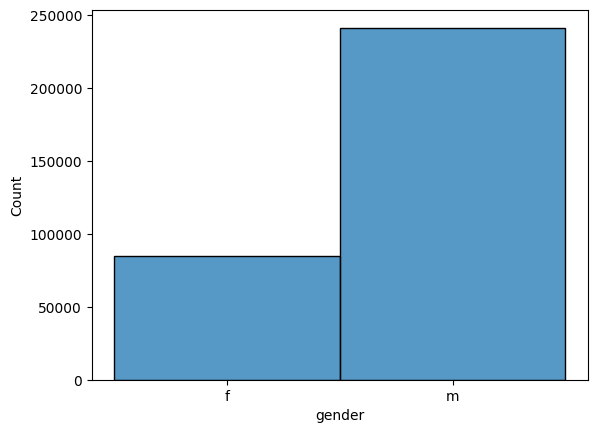

In [131]:
sns.histplot(rec_users['gender'])